In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import sntd, sncosmo, os
#from utils_suhail import *
%load_ext autoreload
%autoreload 2

In [2]:
#doubles_df = pd.read_pickle('../lensed_SNe/Sims_Storage_fromNikki/Baselinev20_numimages=2_batch001.pkl')
doubles_df = pd.read_pickle('../processed_data/Baseline_v_3_0//Baselinev30_NEW_large_numimages=2_batch001.pkl')



In [3]:
index_list = np.loadtxt('../processed_data/Doubles_dt_gold_sample.txt')
#lc_tab = to_sntd(doubles_df, good_index[0])
good_index = np.where(index_list == 1)[0]
#print(good_index)
peak_mag = [[doubles_df['obs_peak'][i][2][0], doubles_df['obs_peak'][i][2][1]]  for i in good_index]
peak_mag = np.array(peak_mag)
#print(peak_mag)
#print(doubles_df['obs_peak'][2][0])
best_index = good_index[(peak_mag[:,0] <= 22.5) & (peak_mag[:,1] <= 22.5)] 

In [4]:
print(best_index)

[ 63  72 186 345 429 438 444 573 605 615 774 875 958 965 972 983 994]


In [5]:
print(best_index)

[ 63  72 186 345 429 438 444 573 605 615 774 875 958 965 972 983 994]


In [5]:
def to_salt(df, i, im_val, filt_ls = ['g', 'r', 'i', 'z', 'y']):
    lc_tab = Table()
    lc_tab.meta['z'] = df['z_source'][i]
    lc_tab.meta['zlens'] = df['z_lens'][i]
    lc_tab.meta['time_delay'] = df['time_delay'][i]
    lc_tab.meta['magnification'] = df['macro_mag'][i]
    times = np.array(df['obs_times'][i])
    bands = np.array(df['obs_bands'][i])
    mags = df['brightness_im'][i]
    mjd = []
    bval = []
    flux_arr = []
    flux_err_arr = []
    zp = []
    zpsys = []
    eflux = 0.1
    for filtval in filt_ls: 
    
        mask_f = np.where(bands == filtval)
        tval = times[mask_f]
        magval = mags[mask_f]
        for jj, val in enumerate(tval):
            mjd.append(val)
            #print(filtval)
            #print(magval)
            bval.append('lsst'+filtval)
        
            
            if magval[jj][im_val - 1] < 40:
                flux = pow(10, -0.4 * (magval[jj][im_val-1] - 25))
                #flux += fval
                flux_err = (2.5 / np.log(10)) * eflux * flux
                #flux_err = #np.sqrt(flux_err ** 2. + efval ** 2.)
            else:
                flux = -99
                flux_err = -99 
            #if magval[jj][im_val] < 40: 
            #    fval = pow(10, -0.4 * (magval[jj][0] - 25))
            #    flux += fval
            #    efval = (2.5 / np.log(10)) * eflux * flux
            #    flux_err = np.sqrt(flux_err ** 2. + efval ** 2.)
            flux_arr.append(flux)
            flux_err_arr.append(flux_err)
            zp.append(25)
            zpsys.append('ab')
    lc_tab['time'] = mjd
    lc_tab['band'] = bval
    lc_tab['flux'] = flux_arr
    lc_tab['fluxerr'] = flux_err_arr
    lc_tab['zp'] = zp
    lc_tab['zpsys'] = zpsys
    return lc_tab 

In [6]:
glSN_im1 = to_salt(doubles_df, best_index[0], 1)
glSN_im2 = to_salt(doubles_df, best_index[0], 2)
print(doubles_df.keys())

NameError: name 'Table' is not defined

In [7]:
doubles_df['time_delay'][429]
doubles_df['obs_times'][429]

array([-28.18145625, -24.29284919, -24.26221227, -24.2319502 ,
       -13.79467093, -13.794859  , -12.71476626, -12.69537465,
        -8.21267092,  -8.18828272,  -5.35711996,  -5.33311485,
        -3.2161099 ,  -3.19179006,   5.59890639,   5.62318386,
        12.77559973,  14.29038135,  14.29001126,  17.76267287,
        17.78683562,  19.6248576 ,  19.64946784,  20.77359594,
        20.79769655,  24.77118498,  40.64637365,  40.67089479,
        42.70924391,  45.64772784,  45.67195545,  48.4262478 ,
        48.46094325,  49.66218743,  54.59003528,  56.65701463,
        61.64615835,  61.67038031,  80.48260856])

In [8]:
#sequentially fit salt to the images and fix x1 to get time-delay

dust = sncosmo.CCM89Dust()
model = sncosmo.Model('salt2-extended', effects=[sncosmo.CCM89Dust()],
                           effect_names=['MW'],
                           effect_frames=['obs'])
print(model.param_names)

def fit_salt(df, indexx, model, savefig=True):
    z = df['z_source'][indexx]
    model['z'] = z
    lc_im1 = to_salt(df, indexx, 1)
    lc_im1_det = lc_im1[lc_im1['flux'] / lc_im1['fluxerr'] >= 3]
    lc_im2 = to_salt(df, indexx, 2)
    lc_im2_det = lc_im2[lc_im2['flux'] / lc_im2['fluxerr'] >= 3]
    res1, fitted_model1 = sncosmo.fit_lc(lc_im1_det, model, ['t0', 'x0', 'x1', 'c'], modelcov=True)
    input_deltaT = df['time_delay'][indexx][1] - df['time_delay'][indexx][0]
    model['x1'] = res1.parameters[3]
    model['c']  = res1.parameters[4]
    #print(res1.errors)
    res2, fitted_model2 = sncosmo.fit_lc(lc_im2_det, model, ['t0', 'x0'], modelcov=True)
    if savefig: 
        sncosmo.plot_lc(lc_im1_det, fitted_model1, errors=res1.errors, fname='outputs/plots/resolved_timedelay/gLSN_'+str(ii)+'_image1.png')
        sncosmo.plot_lc(lc_im2_det, model=fitted_model2, errors=res2.errors, fname='outputs/plots/resolved_timedelay/gLSN_'+str(ii)+'_image2.png')
    infer_deltaT = res2.parameters[1] - res1.parameters[1]
    sig_infer_deltaT = np.sqrt(res1.errors['t0'] ** 2. + res2.errors['t0'] ** 2.)
    return infer_deltaT, sig_infer_deltaT, input_deltaT

infer_input_arr = []
#for ii in best_index:
for ii in good_index: 
    inferT, sigma, input_dt = fit_salt(doubles_df, ii, model)
    print(inferT, sigma, input_dt)
    infer_input_arr.append([ii, inferT, sigma, input_dt])
print(infer_input_arr)
np.savetxt('outputs/metafiles/infer_timedelay_doubles.txt', infer_input_arr, fmt='%s')


['z', 't0', 'x0', 'x1', 'c', 'MWebv', 'MWr_v']


NameError: name 'Table' is not defined

In [9]:
infer_input_arr = np.array(infer_input_arr)
dif = infer_input_arr[:,1] - infer_input_arr[:,3]
cond = infer_input_arr[:,2] <= 10
print(doubles_df.keys())
infer_input_clean = infer_input_arr[cond]
theta_arr = [doubles_df['theta_E'][i[0]] for i in infer_input_clean]
print(theta_arr)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [10]:
infer_input_arr = np.loadtxt('outputs/metafiles/infer_timedelay_doublesv30_400_700.txt')
#infer_input_arr = np.loadtxt('outputs/metafiles/infer_timedelay_doublesv30_400_700.txt')
print(len(infer_input_arr[:,0]))

FileNotFoundError: outputs/metafiles/infer_timedelay_doublesv30_400_700.txt not found.

In [24]:
## Get goodness of fit criteria
goodness_offit = []
micro_lens = False
if micro_lens:
    outdir = 'outputs/WithWeather/microlensing/'
else:
    outdir = 'outputs/WithWeather/'
for ii in infer_input_arr:
    if ii[1] != -99:
        f1 = outdir+'fitparams_gLSN_v30_'+str(int(ii[0]))+'_doubles_1.pkl'
        f2 = outdir+'fitparams_gLSN_v30_'+str(int(ii[0]))+'_doubles_2.pkl'
        if os.path.exists(f1) and os.path.exists(f2):
            res1 = pd.read_pickle(f1)
            res2 = pd.read_pickle(f2)
            rchi = res1.chisq / res1.ndof
            rchi2 = res2.chisq / res2.ndof
        #print(res2.errors)
            goodness_offit.append([ii[0], ii[1], ii[2], ii[3], res1.errors['x1'], rchi, rchi2])
#print(goodness_offit)
#print(goodness_offit)

Total number of fits are:  294
Out of those, the ones with reasonable error bars are:  38
difference within 5% 28
difference with one day 16
Indices with differences > 1 day [403. 428. 436. 450. 455. 466. 485. 488. 522. 536. 573. 603. 604. 620.
 621. 627. 638. 650. 670. 679. 681. 697.]
Indices with differences < 1 day [408. 412. 420. 438. 446. 476. 511. 530. 570. 578. 580. 587. 605. 606.
 615. 636.]
Time delays with differences < 1 day [35.17703923 56.50061421  8.9952975  58.05053118  5.38876745  6.91811669
 11.07953409  0.93602615 38.10508109  2.54282662 29.89491729  4.36055621
  6.24027095  3.49372005 18.61339429 11.14042284]
12


Text(0, 0.5, 'Inferred $\\Delta$ t - Input')

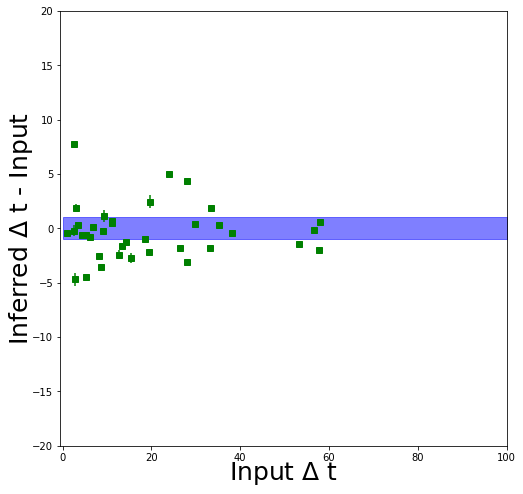

In [19]:
#infer_input_arr = np.array(infer_input_arr)
plt.figure(figsize=(8,8))
goodness_offit = np.array(goodness_offit)
dif = goodness_offit[:,1] - goodness_offit[:,3]
nredchi = 10
cond = (goodness_offit[:,2] <= 1) & (goodness_offit[:,3] >= 0) & (goodness_offit[:,-2] <= nredchi) & (goodness_offit[:,-1] <= nredchi)  & (goodness_offit[:,-3] <= 1)  
cond1 = (goodness_offit[:,2] <= 2) & (goodness_offit[:,3] >= 0) & (abs(dif) >= 5)

print("Total number of fits are: ", len(infer_input_arr))
print("Out of those, the ones with reasonable error bars are: ", len(goodness_offit[cond]))
print('difference within 5%', len(dif[cond][dif[cond] / (goodness_offit[:,3][cond]) <= .05]))
print('difference with one day', len(dif[cond][abs(dif[cond]) <= 1.]))
print('Indices with differences > 1 day', goodness_offit[:,0][cond][abs(dif[cond]) >= 1.])
print('Indices with differences < 1 day', goodness_offit[:,0][cond][abs(dif[cond]) < 1.])
print('Time delays with differences < 1 day', goodness_offit[:,3][cond][abs(dif[cond]) < 1.])


best_infer = goodness_offit[cond][abs(dif[cond]) <= 1]
theta_E_best = np.array([doubles_df['theta_E'][i[0]] for i in best_infer])

#print("Indices which pass the cuts ", goodness_offit[:,0][cond])
print(len(best_infer[theta_E_best >= 0.5]))
plt.errorbar(goodness_offit[:,3][cond], dif[cond], yerr=goodness_offit[:,2][cond], fmt='gs')
plt.fill_between([0, 100], -1, 1, alpha=0.5, color='b')
#print(infer_input_arr[:,0][cond], infer_input_arr[:,0][cond1])
plt.ylim(-20, 20)
plt.xlim(-0.5, 100)
plt.xlabel('Input $\Delta$ t', fontsize=25, labelpad=-3)
plt.ylabel('Inferred $\Delta$ t - Input', fontsize=25, labelpad=-3)
#plt.savefig('outputs/plots/input_inferred_deltaT_randomIndex_WithWeather_quads_fitCut.png')
#best_indexx = goodness_offit[cond][abs(dif[cond]) <= 1.][:,0]

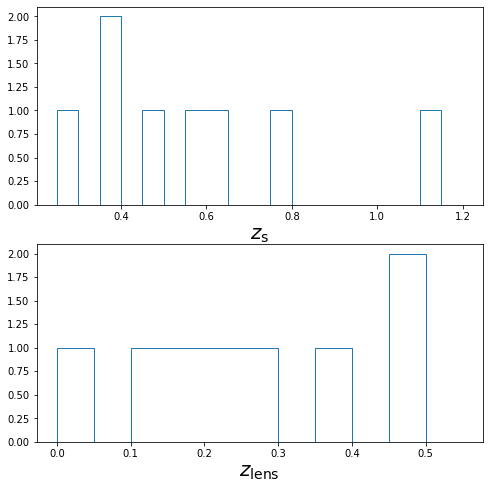

In [16]:
sourcez_best = np.array([doubles_df['z_source'][ii] for ii in best_indexx])
lensz_best = np.array([doubles_df['z_lens'][ii] for ii in best_indexx])
plt.figure(1, figsize=(8,8))
plt.subplot(211)
plt.hist(sourcez_best, histtype='step', bins=np.arange(0.25, 1.25, 0.05))
plt.xlabel(r'$z_{\rm s}$', fontsize=20)


plt.subplot(212)
plt.hist(lensz_best, histtype='step', bins=np.arange(0.0, 0.6, 0.05))
plt.xlabel(r'$z_{\rm lens}$', fontsize=20)
plt.savefig('outputs/plots/redshift_hist.pdf')



In [35]:
import os 
trans_mjd = 60768
tag_arr = []
#infer_input_arr = np.array(infer_input_arr)
dif = infer_input_arr[:,1] - infer_input_arr[:,3]
cond = (infer_input_arr[:,2] <= 10) & (infer_input_arr[:,3] >= 0)
best_infer = infer_input_arr[cond][abs(dif[cond]) <= 1]
for indexx in best_infer[:,0]:
    
    obs_st = doubles_df['obs_start'][indexx]
    if obs_st <= trans_mjd:
        tag_arr.append('Non-Rolling')
    else:
        tag_arr.append('Rolling')

In [36]:
tag_arr = np.array(tag_arr)
len(tag_arr[tag_arr=='Rolling']), len(tag_arr)

(6, 11)

## Summary statistics for Quads / Doubles (without SALT2 / time-delay fits )

In [19]:
doubles_df.keys()

Index(['time_series', 'z_source', 'z_lens', 'H0', 'theta_E', 'obs_peak',
       'obs_times', 'obs_bands', 'model_mag', 'obs_mag', 'obs_mag_error',
       'obs_snr', 'obs_mag_unresolved', 'mag_unresolved_error',
       'snr_unresolved', 'macro_mag', 'source_x', 'source_y', 'time_delay',
       'time_delay_distance', 'image_x', 'image_y', 'gamma_lens', 'e1_lens',
       'e2_lens', 'g1_shear', 'g2_shear', 'micro_kappa', 'micro_gamma',
       'micro_s', 'micro_peak', 'stretch', 'colour', 'Mb', 'obs_start',
       'obs_end', 'mult_method_peak', 'mult_method', 'mag_method_peak',
       'mag_method', 'coords', 'obs_skybrightness', 'obs_psf', 'obs_lim_mag',
       'obs_N_coadds'],
      dtype='object')

In [34]:
doubles_df.keys()
pre_peak_obs = []
dict_peak = {}
for ii, tval in enumerate([doubles_df['obs_peak']]):
    t_arr = doubles_df['obs_times'][ii]
    f_arr = doubles_df['obs_bands'][ii]
    mag_arr = doubles_df['obs_mag_unresolved'][ii]
    mag_err_arr = doubles_df['mag_unresolved_error'][ii]
    lc = np.vstack([t_arr, f_arr, mag_arr, mag_err_arr]).T
    cond_det = mag_err_arr <= 0.3
    lc_det = lc[cond_det]
    print(lc_det[:,2])
    early_cond = lc_det[:,2].astype('float32') == min(lc_det[:,2].astype('float32'))
    f_early = lc_det[:,1][early_cond]

    f_len = []
    for fval in np.unique(f_early):
        ll = len(f_early[f_early == fval])
        f_len.append([fval, ll])
    dict_peak['SN'+str(ii)] = f_len

['22.340204826793386' '21.500099451524303' '22.59505154564142'
 '21.528402120079917' '21.59362233399996' '21.957708108996908'
 '21.885098054448083' '21.55094477337672' '22.53219397125866'
 '22.518508516172602']


In [50]:
print(dict_peak)
sncosmo.get_bandpass('')

{'SN0': [['i', 1]]}


Exception: '' not in registry. Registered names: 'f555w', 'ps1::y', 'swope2::b', 'keplercam::r', '4shooter2::b', 'uvot::v', 'sdssu', 'f763m', 'ps1::g', 'bessellr', 'f090w', 'f1550c', 'cspr', 'bessellux', 'bessellv', 'swope2::i', '4shooter2::us', 'uvot::u', 'nicf110w', 'uvot::uvw2', 'keplercam::us', 'desy', 'f139m', 'lssty', 'uvot::b', '4shooter2::i', 'cspv9844', 'uvot::uvw1', 'f277w', 'lssti', 'lsstg', 'f087', 'f475w', 'swope2::v', 'cspjs', 'csphs', 'f129', '4shooter2::r', 'lsstr', 'f162m', 'f444w', 'f250m', 'cspv3014', 'cspu', 'f560w', 'f770w', 'f275w', 'f300m', 'ztfr', 'nicmos2::f160w', 'f480m', 'standard::b', '4shooter2::v', 'cspi', 'f1130w', 'uvf606w', 'f410m', 'f062', 'cspyd', 'swope2::u', 'f689m', 'standard::r', 'acswf::f850lp', 'acswf::f775w', 'f110w', 'f2100w', 'uvf814w', 'f430m', 'sdss::z', 'f127m', 'sdssi', 'f460m', 'f158', 'swope2::r', 'keplercam::v', 'desg', 'sdssr', 'f1140c', 'sdss::r', 'acswf::f606w', 'besselli', 'sdssz', 'nicf160w', 'sdssg', 'cspjd', 'f184', 'f153m', 'ps1::open', 'f1000w', 'swope2::y', 'swope2::v1', 'f070w', 'ps1::w', 'f435w', 'f2300c', 'f105w', 'f115w', 'desz', 'uvf555w', 'ps1::i', 'sdss::g', 'uvf625w', 'f182m', 'cspb', 'swope2::j', 'f2550w', 'standard::u', 'cspk', 'cspv3009', 'f213', 'ps1::z', 'f125w', 'f106', 'sdss::i', 'f390w', 'f350lp', 'lsstu', 'ztfi', 'standard::i', 'f775w', 'uvf775w', 'bessellb', 'cspg', 'f1800w', 'ps1::r', 'uvot::uvm2', 'nicmos2::f110w', 'f356w', 'f1065c', 'f438w', 'lsstz', 'f625w', 'csphd', 'f1280w', 'swope2::h', 'swope2::v2', 'desr', 'f140w', 'f606w', 'f218w', 'standard::v', 'f850lp', 'f200w', 'ztfg', 'uvf475w', 'keplercam::b', 'kepler', 'f098m', 'f360m', 'f1500w', 'f146', 'uvot::white', 'f225w', 'f335m', 'desi', 'swope2::g', 'f336w', 'f845m', 'sdss::u', 'f140m', 'f210m', 'uvf850lp', 'f160w', 'f300x', 'keplercam::i', 'cspys', 'f150w'

In [46]:
mod_str = 'salt2-extended'
model = sncosmo.Model(mod_str, effects=[sncosmo.CCM89Dust()],
                           effect_names=['MW'],
                           effect_frames=['obs'])

print(doubles_df.keys())

Index(['time_series', 'z_source', 'z_lens', 'H0', 'theta_E', 'obs_peak',
       'obs_times', 'obs_bands', 'model_mag', 'obs_mag', 'obs_mag_error',
       'obs_snr', 'obs_mag_unresolved', 'mag_unresolved_error',
       'snr_unresolved', 'macro_mag', 'source_x', 'source_y', 'time_delay',
       'time_delay_distance', 'image_x', 'image_y', 'gamma_lens', 'e1_lens',
       'e2_lens', 'g1_shear', 'g2_shear', 'micro_kappa', 'micro_gamma',
       'micro_s', 'micro_peak', 'stretch', 'colour', 'Mb', 'obs_start',
       'obs_end', 'mult_method_peak', 'mult_method', 'mult_method_micro',
       'mag_method_peak', 'mag_method', 'mag_method_micro', 'coords',
       'obs_skybrightness', 'obs_psf', 'obs_lim_mag', 'obs_N_coadds', 'survey',
       'rolling', 'obs_mag_micro', 'mag_micro_error', 'obs_snr_micro',
       'mag_unresolved_micro', 'mag_unresolved_micro_error',
       'snr_unresolved_micro', 'peak_magnitudes', 'peak_magnitudes_micro'],
      dtype='object')


In [52]:
print(doubles_df['time_delay'][636], doubles_df['z_lens'][636])

[ 0.         11.14042284] 0.14216477466591207


In [26]:
def get_model_mag(indexx, imval, bpval, tval, direc='outputs/WithWeather/'):
    ff = pd.read_pickle(direc+'fitparams_gLSN_v30_'+str(indexx)+'_doubles_'+str(imval)+'.pkl')
    model['z'] = ff.parameters[0]
    model['t0'] = ff.parameters[1]
    model['x0'] = ff.parameters[2]
    model['x1'] = ff.parameters[3]
    model['c'] = ff.parameters[4]
    modmag = model.bandmag('lsst'+bpval, 'ab', tval)
    return modmag

636
636
636
636
636
636
636
636


/opt/anaconda3/lib/python3.9/site-packages/sncosmo/models.py:189: RuntimeWarning: divide by zero encountered in log10
  result[i] = -2.5 * np.log10(f / zpf)
/opt/anaconda3/lib/python3.9/site-packages/sncosmo/models.py:189: RuntimeWarning: divide by zero encountered in log10
  result[i] = -2.5 * np.log10(f / zpf)
/opt/anaconda3/lib/python3.9/site-packages/sncosmo/models.py:189: RuntimeWarning: divide by zero encountered in log10
  result[i] = -2.5 * np.log10(f / zpf)
/opt/anaconda3/lib/python3.9/site-packages/sncosmo/models.py:189: RuntimeWarning: divide by zero encountered in log10
  result[i] = -2.5 * np.log10(f / zpf)


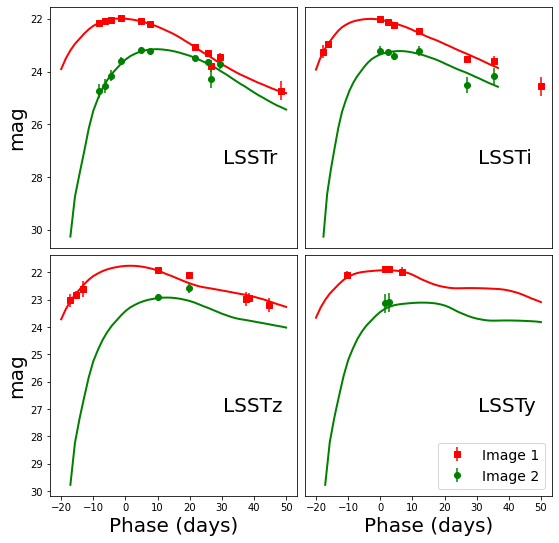

In [42]:
from utils_suhail import to_sncosmo, to_salt
from matplotlib.gridspec import GridSpec
import sncosmo
indexx = 636
gs = GridSpec(2, 2)
plt.figure(1, figsize=(9,9))
bp_arr = ['lsstr', 'lssti', 'lsstz', 'lssty']
for ii, val in enumerate(gs):
    plt.subplot(val)
    lc1 = to_salt(doubles_df,indexx,  1)
    lc1 = lc1[lc1['flux'] / lc1['fluxerr'] >= 3]
    lc2 = to_salt(doubles_df, indexx,2)
    lc2 = lc2[lc2['flux'] / lc2['fluxerr'] >= 3]
    #print(np.unique(lc1['band'])) 
    t1 = lc1['time']
    t2 = lc2['time']
    bpval = bp_arr[ii]
    cond = lc1['band'] == bpval
    cond2 = lc2['band'] == bpval

    mag1 = -2.5 * np.log10(lc1['flux']) + lc1['zp']
    mag2 = -2.5 * np.log10(lc2['flux']) + lc2['zp']

    magerr1 = (2.5) / np.log(10) * (lc1['fluxerr'] / lc1['flux'])
    magerr2 = (2.5) / np.log(10) * (lc2['fluxerr'] / lc2['flux'])

    tt = np.linspace(-20, 50)

    mod1 = get_model_mag(indexx, 1, bpval[-1], tt)
    mod2 = get_model_mag(indexx, 2, bpval[-1], tt)
    plt.annotate(bpval.upper()[:-1]+bpval[-1], xy=(0.7, 0.35), xycoords="axes fraction", fontsize=20)

    plt.errorbar(t1[cond], mag1[cond], magerr1[cond], fmt='rs', label='Image 1')
    plt.plot(tt, mod1, color='r', linewidth=2)
    plt.errorbar(t2[cond2], mag2[cond2], magerr2[cond2], fmt='go', label='Image 2')
    plt.plot(tt, mod2, color='g', linewidth=2)
    plt.ylim(plt.ylim()[::-1])
    if ii==0 or ii == 2:
        plt.ylabel("mag", fontsize=20)
    else:
        plt.yticks([])
    if ii > 1:
        plt.xlabel("Phase (days)", fontsize=20)
    else:
        plt.xticks([])
plt.subplots_adjust(hspace=0.03, wspace=0.03)
plt.legend(loc=0, prop={'size':14})
#plt.title("SN "+str(indexx) + " " + bpval, fontsize=20)
plt.savefig('outputs/plots/example_multIm_goodIndex_double_multfilt.pdf')

NameError: name 'Table' is not defined

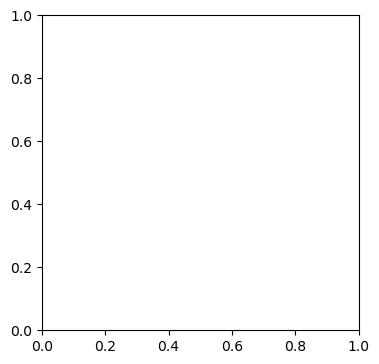

In [12]:
# from utils_suhail import to_sncosmo, to_salt
from matplotlib.gridspec import GridSpec
import sncosmo
indexx = 636
gs = GridSpec(2, 2)
plt.figure(1, figsize=(9,9))
bp_arr = ['lsstr', 'lssti', 'lsstz', 'lssty']
for ii, val in enumerate(gs):
    plt.subplot(val)
    lc1 = to_salt(doubles_df,indexx,  1)
    lc1 = lc1[lc1['flux'] / lc1['fluxerr'] >= 3]
    lc2 = to_salt(doubles_df, indexx,2)
    lc2 = lc2[lc2['flux'] / lc2['fluxerr'] >= 3]
    #print(np.unique(lc1['band'])) 
    t1 = lc1['time']
    t2 = lc2['time']
    bpval = bp_arr[ii]
    cond = lc1['band'] == bpval
    cond2 = lc2['band'] == bpval

    mag1 = -2.5 * np.log10(lc1['flux']) + lc1['zp']
    mag2 = -2.5 * np.log10(lc2['flux']) + lc2['zp']

    magerr1 = (2.5) / np.log(10) * (lc1['fluxerr'] / lc1['flux'])
    magerr2 = (2.5) / np.log(10) * (lc2['fluxerr'] / lc2['flux'])

    tt = np.linspace(-20, 50)

    mod1 = get_model_mag(indexx, 1, bpval[-1], tt)
    mod2 = get_model_mag(indexx, 2, bpval[-1], tt)
    plt.annotate(bpval.upper()[:-1]+bpval[-1], xy=(0.7, 0.35), xycoords="axes fraction", fontsize=20)

    plt.errorbar(t1[cond], mag1[cond], magerr1[cond], fmt='rs', label='Image 1')
    plt.plot(tt, mod1, color='r', linewidth=2)
    plt.errorbar(t2[cond2], mag2[cond2], magerr2[cond2], fmt='go', label='Image 2')
    plt.plot(tt, mod2, color='g', linewidth=2)
    plt.ylim(plt.ylim()[::-1])
    if ii==0 or ii == 2:
        plt.ylabel("mag", fontsize=20)
    else:
        plt.yticks([])
    if ii > 1:
        plt.xlabel("Phase (days)", fontsize=20)
    else:
        plt.xticks([])
plt.subplots_adjust(hspace=0.03, wspace=0.03)
plt.legend(loc=0, prop={'size':14})
#plt.title("SN "+str(indexx) + " " + bpval, fontsize=20)
#plt.savefig('outputs/plots/example_multIm_goodIndex_double_multfilt.pdf')